## Imports

#### General

In [1]:
import pandas as pd
import numpy as np

#### For clustering

In [2]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import SpectralClustering

#### For plotting

In [3]:
import matplotlib.pyplot as plt

## Read in the data

### Read in data 1

In [4]:
df_pvl_delta = pd.read_csv("./data/parameter_igt_pvl_delta.csv")

#### Inspect the data

In [5]:
df_pvl_delta.head()

,group,SubID,LR,Outcome_Sens,Response_cons,Loss_Aver
0,young,1,0.159011,0.487522,0.686815,0.954498
1,young,2,0.064666,0.511008,1.391790,0.295529
2,young,3,0.113089,0.465141,0.918734,0.533232
3,young,4,0.089273,0.500391,0.703737,0.869859
4,young,5,0.233898,0.488053,0.897867,0.511095


In [6]:
df_pvl_delta.describe()

,SubID,LR,Outcome_Sens,Response_cons,Loss_Aver
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,77.000000,0.254555,0.490149,1.047426,0.771240
std,44.311398,0.237008,0.155386,0.400147,0.651220
min,1.000000,0.024038,0.049304,0.590758,0.043900
25%,39.000000,0.089273,0.401523,0.730751,0.282991
50%,77.000000,0.158341,0.490751,0.918049,0.660665
75%,115.000000,0.294708,0.560787,1.284732,1.054360
max,153.000000,0.942930,0.925102,2.449047,4.084854


In [37]:
df_pvl_delta.drop(columns=['SubID'], axis=1, inplace=True)

In [38]:
df_pvl_delta.head()

,group,LR,Outcome_Sens,Response_cons,Loss_Aver
0,young,0.159011,0.487522,0.686815,0.954498
1,young,0.064666,0.511008,1.391790,0.295529
2,young,0.113089,0.465141,0.918734,0.533232
3,young,0.089273,0.500391,0.703737,0.869859
4,young,0.233898,0.488053,0.897867,0.511095


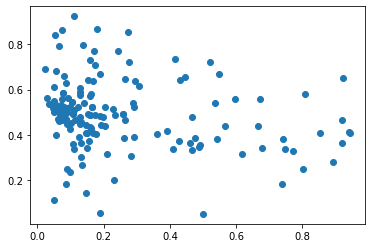

In [7]:
plt.scatter(df_pvl_delta["LR"], df_pvl_delta["Outcome_Sens"])

### Read in data 2

In [8]:
df_orl = pd.read_csv("./data/parameter_igt_orl.csv")

#### Inspect the data

In [9]:
df_orl.head()

,subjID,A+,A-,K,BetaF,BetaP,A+-A-
0,old,0.324444,0.068862,1.502130,2.523191,-5.547480,0.255581
1,old,0.885744,0.120145,0.012591,3.193244,-9.159800,0.765598
2,old,0.318205,0.078128,1.927309,0.615708,9.272336,0.240077
3,old,0.728192,0.106737,0.388407,2.595746,-2.239555,0.621455
4,old,0.356229,0.091987,1.810674,0.508605,9.825699,0.264241


#### Rename subjID column

In [10]:
df_orl.rename(columns={'subjID':'group'}, inplace=True)
df_orl.head()

,group,A+,A-,K,BetaF,BetaP,A+-A-
0,old,0.324444,0.068862,1.502130,2.523191,-5.547480,0.255581
1,old,0.885744,0.120145,0.012591,3.193244,-9.159800,0.765598
2,old,0.318205,0.078128,1.927309,0.615708,9.272336,0.240077
3,old,0.728192,0.106737,0.388407,2.595746,-2.239555,0.621455
4,old,0.356229,0.091987,1.810674,0.508605,9.825699,0.264241


### Read in data 3

In [11]:
df_vpp = pd.read_csv("./data/parameters_igt_vpp.csv")

#### Inspect the data

In [12]:
df_vpp.head()

,group,SubID,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,1,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446
1,young,2,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352
2,young,3,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723
3,young,4,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971
4,young,5,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563


In [13]:
df_vpp.describe()

,SubID,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,77.000000,0.070824,0.560575,1.329323,0.952138,0.460940,-0.720379,0.406367,0.622995
std,44.311398,0.064683,0.111139,0.198041,0.580621,1.185591,1.102656,0.187483,0.066657
min,1.000000,0.027454,0.352471,0.879707,0.193857,-2.977630,-2.912838,0.042780,0.452978
25%,39.000000,0.038294,0.448811,1.202790,0.528927,-0.287230,-1.634716,0.256420,0.569390
50%,77.000000,0.050247,0.590334,1.316736,0.760613,0.593115,-0.779120,0.439912,0.640917
75%,115.000000,0.078495,0.646090,1.428836,1.292569,1.419412,0.137599,0.565139,0.675971
max,153.000000,0.617431,0.818137,1.938694,2.698527,2.559126,1.583109,0.858421,0.744017


In [39]:
df_vpp.drop(columns=['SubID'], axis=1, inplace=True)

In [40]:
df_vpp.head()

,group,LR,Out_Sens,Res_Cons,Loss_Aver,Gain_Impa,Loss_Impa,Deca_Rate,RL_weight
0,young,0.038441,0.630402,1.207295,1.050323,-0.535035,-1.913099,0.669323,0.660446
1,young,0.045673,0.630331,1.628191,0.205205,-0.133367,-1.423580,0.427207,0.719352
2,young,0.045468,0.602974,1.395572,0.383055,-0.344822,-1.719826,0.493249,0.688723
3,young,0.035789,0.635677,1.067831,0.823790,-0.229192,-1.484455,0.625835,0.675971
4,young,0.060655,0.636276,1.802964,0.329246,-0.616020,-2.561017,0.439912,0.655563


## Determine the best number of clusters

#### Set up the data for clustering

In [14]:
train_x = df_pvl_delta.iloc[:, 2:]

In [15]:
train_x.head()

,LR,Outcome_Sens,Response_cons,Loss_Aver
0,0.159011,0.487522,0.686815,0.954498
1,0.064666,0.511008,1.391790,0.295529
2,0.113089,0.465141,0.918734,0.533232
3,0.089273,0.500391,0.703737,0.869859
4,0.233898,0.488053,0.897867,0.511095


In [16]:
train_x.describe()

,LR,Outcome_Sens,Response_cons,Loss_Aver
count,153.000000,153.000000,153.000000,153.000000
mean,0.254555,0.490149,1.047426,0.771240
std,0.237008,0.155386,0.400147,0.651220
min,0.024038,0.049304,0.590758,0.043900
25%,0.089273,0.401523,0.730751,0.282991
50%,0.158341,0.490751,0.918049,0.660665
75%,0.294708,0.560787,1.284732,1.054360
max,0.942930,0.925102,2.449047,4.084854


## Create an elbow curve to determine the best number of clusters

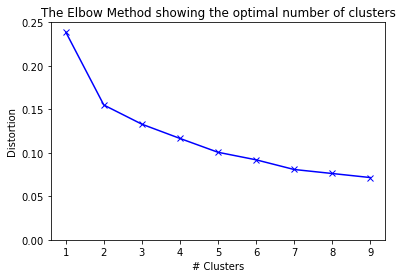

In [17]:
col_1 = train_x.iloc[:, 0]
col_2 = train_x.iloc[:, 1]

# create new plot and data
X = np.array(list(zip(col_1, col_2))).reshape(len(col_1), 2)

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('# Clusters')
plt.ylabel('Distortion')
plt.ylim([0, 0.25])
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()

### Use the above graph to set the number of clusters

In [18]:
num_clusters = 7

## Find out which of the 7 clusters each df row is in

#### Cluster the data

In [19]:
clustering = SpectralClustering(n_clusters=num_clusters, assign_labels="discretize", random_state=0).fit(train_x)
clusters_label = pd.DataFrame(clustering.labels_).rename(columns={0: "Cluster"})

#### Add a new column to the original data with the cluster each row is in

In [20]:
full_df = pd.concat([df_pvl_delta, clusters_label], axis=1)

In [21]:
full_df.head()

,group,SubID,LR,Outcome_Sens,Response_cons,Loss_Aver,Cluster
0,young,1,0.159011,0.487522,0.686815,0.954498,4
1,young,2,0.064666,0.511008,1.391790,0.295529,6
2,young,3,0.113089,0.465141,0.918734,0.533232,4
3,young,4,0.089273,0.500391,0.703737,0.869859,4
4,young,5,0.233898,0.488053,0.897867,0.511095,4


## Principal Component Analysis

#### Inspect dataframe which PCA is being performed on

In [22]:
df_orl.head()

,group,A+,A-,K,BetaF,BetaP,A+-A-
0,old,0.324444,0.068862,1.502130,2.523191,-5.547480,0.255581
1,old,0.885744,0.120145,0.012591,3.193244,-9.159800,0.765598
2,old,0.318205,0.078128,1.927309,0.615708,9.272336,0.240077
3,old,0.728192,0.106737,0.388407,2.595746,-2.239555,0.621455
4,old,0.356229,0.091987,1.810674,0.508605,9.825699,0.264241


#### Standardising the data

In [23]:
from sklearn.preprocessing import StandardScaler

features = df_orl.columns[3:]

# Separating out the features
x = df_orl.loc[:, features].values
# Separating out the target
y = df_orl.loc[:,['group']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

#### PCA projection to 2D

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df_vpp[['group']]], axis = 1)

#### Visualise 2D projection

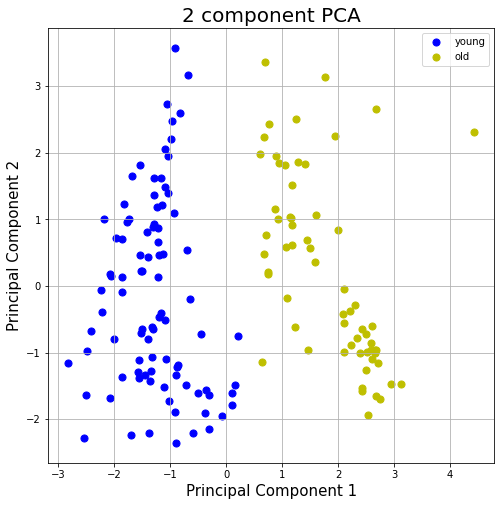

In [25]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['young', 'old']
colors = ['b', 'y']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['group'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

#### Explained Variance

In [26]:
pca.explained_variance_ratio_

array([0.35076363, 0.25256747])

## Plot the clusters

#### Choose the columns to plot

In [27]:
x = full_df.iloc[:, 2]
y = full_df.iloc[:, 3]

#### Plot the original data

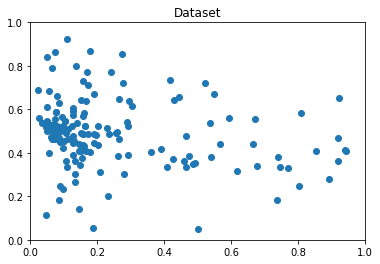

In [28]:
plt.plot()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Dataset')
plt.scatter(x, y)
plt.show()

#### Plot this data with the clusters

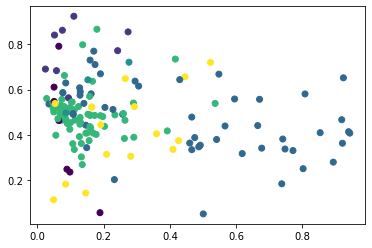

In [29]:
plt.scatter(x, y, c=full_df["Cluster"])

#### Plot this data with the clusters and their centroids

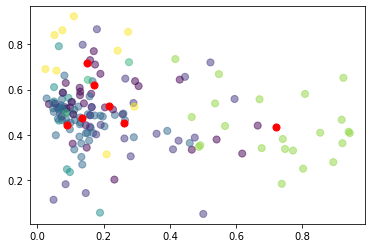

In [30]:
kmeans = KMeans(n_clusters=num_clusters).fit(train_x)
centroids = kmeans.cluster_centers_

plt.scatter(x, y, c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

## See how the 'Old' and 'Young' fall into these clusters

In [31]:
full_df.head()

,group,SubID,LR,Outcome_Sens,Response_cons,Loss_Aver,Cluster
0,young,1,0.159011,0.487522,0.686815,0.954498,4
1,young,2,0.064666,0.511008,1.391790,0.295529,6
2,young,3,0.113089,0.465141,0.918734,0.533232,4
3,young,4,0.089273,0.500391,0.703737,0.869859,4
4,young,5,0.233898,0.488053,0.897867,0.511095,4


#### Create a dataframe showing how many people people fell into each cluster

In [32]:
all_cluster_df = pd.DataFrame(full_df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "All"})

#### Change 'young' to 1 and 'old' to np.nan

In [33]:
full_df["group"] = full_df["group"].replace('old', np.nan).replace('young', 1)
full_df.head()

,group,SubID,LR,Outcome_Sens,Response_cons,Loss_Aver,Cluster
0,1.0,1,0.159011,0.487522,0.686815,0.954498,4
1,1.0,2,0.064666,0.511008,1.391790,0.295529,6
2,1.0,3,0.113089,0.465141,0.918734,0.533232,4
3,1.0,4,0.089273,0.500391,0.703737,0.869859,4
4,1.0,5,0.233898,0.488053,0.897867,0.511095,4


#### Create a dataframe showing how many young people fell into each cluster

In [34]:
young_cluster_df = pd.DataFrame(full_df[["group", "Cluster"]].groupby("Cluster").count()).rename(columns={"group": "Young"})

#### Create a dataframe showing how many old people fell into each cluster

In [35]:
old_cluster_df = pd.DataFrame(full_df["group"].isnull().groupby(full_df["Cluster"]).sum().astype(int)).rename(columns={"group": "Old"})

#### Output how many 'young' and 'old' people fell into each cluster

In [36]:
pd.merge(all_cluster_df, pd.merge(young_cluster_df, old_cluster_df, how="inner", on="Cluster"), how="inner", on="Cluster")

,All,Young,Old
Cluster,,,
0,7,4,3
1,8,5,3
2,51,26,25
3,3,3,0
4,67,48,19
6,17,4,13
